In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import time
import requests
import json
import csv
import datetime
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

 # PART 1: GETTING DATA
 Data is extracted from Reddit using the Pushshift API as documented here:  
 &ensp;https://github.com/pushshift/api

## Getting dates to extract data between
The Pushshift API only returns at most 100 posts with each request, so I create a list of dates to pull 100 posts between these dates.

In [ ]:
dates_list = []

# Making list of dates; The 1st and 15th of every moneth from Jan 2010 until Jan 2021
for i in range(10,22):
    for j in range(1,13):
        if len(str(j))==1:
            month = '0'+str(j)
        else: 
            month = str(j)
        dates_list.append('01/{}/20{}'.format(month, i))
        dates_list.append('15/{}/20{}'.format(month, i))


dates_list

['01/01/2010',
 '15/01/2010',
 '01/02/2010',
 '15/02/2010',
 '01/03/2010',
 '15/03/2010',
 '01/04/2010',
 '15/04/2010',
 '01/05/2010',
 '15/05/2010',
 '01/06/2010',
 '15/06/2010',
 '01/07/2010',
 '15/07/2010',
 '01/08/2010',
 '15/08/2010',
 '01/09/2010',
 '15/09/2010',
 '01/10/2010',
 '15/10/2010',
 '01/11/2010',
 '15/11/2010',
 '01/12/2010',
 '15/12/2010',
 '01/01/2011',
 '15/01/2011',
 '01/02/2011',
 '15/02/2011',
 '01/03/2011',
 '15/03/2011',
 '01/04/2011',
 '15/04/2011',
 '01/05/2011',
 '15/05/2011',
 '01/06/2011',
 '15/06/2011',
 '01/07/2011',
 '15/07/2011',
 '01/08/2011',
 '15/08/2011',
 '01/09/2011',
 '15/09/2011',
 '01/10/2011',
 '15/10/2011',
 '01/11/2011',
 '15/11/2011',
 '01/12/2011',
 '15/12/2011',
 '01/01/2012',
 '15/01/2012',
 '01/02/2012',
 '15/02/2012',
 '01/03/2012',
 '15/03/2012',
 '01/04/2012',
 '15/04/2012',
 '01/05/2012',
 '15/05/2012',
 '01/06/2012',
 '15/06/2012',
 '01/07/2012',
 '15/07/2012',
 '01/08/2012',
 '15/08/2012',
 '01/09/2012',
 '15/09/2012',
 '01/10/20

## Converting dates to Unix timestamp
Returns Unix timestamp that Pushshift API requires for dates

In [ ]:
def getTimeStamp(date_input):
    return time.mktime(datetime.datetime.strptime(date_input, "%d/%m/%Y").timetuple())

dates = [int(getTimeStamp(date)) for date in dates_list]
dates

[1262332800,
 1263542400,
 1265011200,
 1266220800,
 1267430400,
 1268636400,
 1270105200,
 1271314800,
 1272697200,
 1273906800,
 1275375600,
 1276585200,
 1277967600,
 1279177200,
 1280646000,
 1281855600,
 1283324400,
 1284534000,
 1285916400,
 1287126000,
 1288594800,
 1289808000,
 1291190400,
 1292400000,
 1293868800,
 1295078400,
 1296547200,
 1297756800,
 1298966400,
 1300172400,
 1301641200,
 1302850800,
 1304233200,
 1305442800,
 1306911600,
 1308121200,
 1309503600,
 1310713200,
 1312182000,
 1313391600,
 1314860400,
 1316070000,
 1317452400,
 1318662000,
 1320130800,
 1321344000,
 1322726400,
 1323936000,
 1325404800,
 1326614400,
 1328083200,
 1329292800,
 1330588800,
 1331794800,
 1333263600,
 1334473200,
 1335855600,
 1337065200,
 1338534000,
 1339743600,
 1341126000,
 1342335600,
 1343804400,
 1345014000,
 1346482800,
 1347692400,
 1349074800,
 1350284400,
 1351753200,
 1352966400,
 1354348800,
 1355558400,
 1357027200,
 1358236800,
 1359705600,
 1360915200,
 1362124800,

## Getting Pushshift data
Returns the top 100 posts in the given subreddit between the given times.  
Code modified from the following article:  
&ensp;https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [ ]:
def getPushshiftData(after, before, sub):
    url = ('https://api.pushshift.io/reddit/search/submission/?size=100&after='+
           str(after)+'&before='+str(before)+'&subreddit='+str(sub)+'&sort_type=score'+'&sort=desc')
    print(url)
    r = requests.get(url)
    r.raise_for_status()
    print ("status code", r.status_code)
    if r.status_code == 200:
       data = json.loads(r.text)
       return data['data']

## Getting all the titles between the dates chosen earlier
Here I loop through all the dates above and get the top 100 posts in the chosen subreddit.   

In [50]:
def getTitles(subreddit):
    titles_new = []
    titles = []

    for i in range(len(dates)-1):
        # Setting up dates
        after  = dates[i]
        before = dates[i+1]

        # Getting subreddit data between the dates after and before from r/NotTheOnion
        raw_json = getPushshiftData(after,before,subreddit)

        # Extracting just the title
        titles_new = [post['title'] for post in raw_json]
        print ('number of titles:', len(titles_new))

        # Appending new data on
        titles = titles + titles_new

        time.sleep(1.1) #so we don't go over 60 requests/minute

    # A few posts were extracted twice, set gets rid of duplicates
    titles = list(set(titles))
    return titles

not_onion = getTitles('nottheonion')
onion = getTitles('theonion')


https://api.pushshift.io/reddit/search/submission/?size=100&after=1262332800&before=1263542400&subreddit=nottheonion&sort_type=score&sort=desc
status code 200
number of titles: 0
https://api.pushshift.io/reddit/search/submission/?size=100&after=1263542400&before=1265011200&subreddit=nottheonion&sort_type=score&sort=desc
status code 200
number of titles: 0
https://api.pushshift.io/reddit/search/submission/?size=100&after=1265011200&before=1266220800&subreddit=nottheonion&sort_type=score&sort=desc
status code 200
number of titles: 1
https://api.pushshift.io/reddit/search/submission/?size=100&after=1266220800&before=1267430400&subreddit=nottheonion&sort_type=score&sort=desc
status code 200
number of titles: 0
https://api.pushshift.io/reddit/search/submission/?size=100&after=1267430400&before=1268636400&subreddit=nottheonion&sort_type=score&sort=desc
status code 200
number of titles: 0
https://api.pushshift.io/reddit/search/submission/?size=100&after=1268636400&before=1270105200&subreddit=

KeyboardInterrupt: 

In [ ]:
print (len(not_onion))
print (len(onion))

20000
12000


I end up with 20457 "fake"-Onion headlines from r/NotThenOnion and 12036 Onion headlines.
I then keep the first 20000 and first 12000 for easier batching. 

In [ ]:
not_onion = not_onion[:20000]
onion = onion[:12000]

## Converting to pandas dataframe
Labeling Onion headlines as 1, and r/NotTheOnion headlines as 0.

In [ ]:
df_onion= pd.DataFrame({'text':onion})
df_onion['label'] = 1

df_notonion = pd.DataFrame({'text':not_onion})
df_notonion['label'] = 0

# Combining both datasets
df = pd.concat([df_onion,df_notonion])

# Shuffling the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Saving the 'uncleaned' dataframe to a csv file
df.to_csv('OnionOrNot.csv', index = False)

# Converting all text to lowercase, fixing ampersands and getting rid
# of dashes and apostrophes as they can mess up the dictionary
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'&amp;', 'and')
df['text'] = df['text'].str.replace(r'-', ' ')
df['text'] = df['text'].str.replace(r'[^\s\w]','')

# Saving the dataframe to a csv file
df.to_csv('OnionOrNotClean.csv', index =False)
df_orig = pd.read_csv("OnionOrNot.csv")

df_merged = pd.merge(df_orig.rename({'text':'orig_title', 'label':'label_x'}, axis = 1), df.rename({'text':'cleaned_title'}, axis = 1), left_index=True, right_index=True)
df_merged[['orig_title', 'cleaned_title', 'label']].head()
df_merged[['orig_title', 'cleaned_title', 'label']].to_csv('OnionOrNotClean.csv', index=False)


,text,label
0,life road to recovery after three long weeks t...,1
1,pizza delivery drivers sixth grandmother dies,1
2,woman gives birth while overdosing on heroin i...,0
3,laura bush publishes courageous op ed calling ...,1
4,reeses launches makeup line yes it smells lik...,0


## Reading in dataframe
Running this when I return to the project so I don't have to use the Pushshift API etc. again.

In [2]:
df = pd.read_csv('OnionOrNotClean.csv')
df.dropna(inplace=True) #nulls cause issues, so we drop them
print (df.shape)
df.head()


NameError: name 'pd' is not defined

# PART 2: ONE HOT ENCODING WORDS AS VECTORS

## Getting all the words in the training data

In [52]:
vocab_set = set()
sentence_lengths = []

for i in range(len(df)):
    # Updates adds all items to the set, re.split splits the text into words
    sentence_words = re.split(r'\s',df.iloc[i]['cleaned_title'])
    vocab_set.update(sentence_words)
    sentence_lengths.append(len(sentence_words))

## Converting the words to a dictionary
This way we can map the words in the dataframe to lists of numbers

In [53]:
vocab_list = list(vocab_set)
vocab_dict = {vocab_list[i-1]: i for i in range(1, len(vocab_list)+1)}

## Creating column of the words mapped to numbers

In [54]:
max_length = max(sentence_lengths)

def toNumbers(row):
    words = re.findall(r'([\w]+)', row['cleaned_title'])
    nums =  np.array([vocab_dict[words[j]] for j in range(len(words))])
    return np.pad(nums, (0, max_length - len(nums)), mode='constant')

In [55]:
nums = df.apply(lambda row: toNumbers(row), axis=1) 
df['nums'] = nums

df['nums'].head()

0    [12201, 18609, 13837, 12933, 7400, 6509, 3527,...
1    [21982, 22398, 1004, 3819, 18219, 2503, 0, 0, ...
2    [8783, 20769, 29675, 13754, 24619, 21149, 2990...
3    [14542, 6554, 20621, 24789, 7069, 9400, 20366,...
4    [25356, 9665, 22826, 5158, 19380, 26723, 3125,...
Name: nums, dtype: object

## Train-Test Split


In [56]:
#split into train-test set with pandas

train_size = 0.8
random_state = 42

df_train = df.sample(frac=train_size,random_state=random_state)
df_test = df.drop(df_train.index).sample(frac=1.0, random_state=random_state)

print (df.shape)
print (df_train.shape)
print (df_test.shape)

(31996, 4)
(25597, 4)
(6399, 4)


## Converting to Numpy

In [57]:
labels_train = np.asarray(df_train['label'].values)
features_train = np.stack(df_train['nums'].values)

labels_test = np.asarray(df_test['label'].values)
features_test = np.stack(df_test['nums'].values)


features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

((25597, 64), (6399, 64), (25597,), (6399,))

# PART 3: MODELS WITH ONE-HOT ENCODING

In [59]:
def plot_train_validation(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [81]:
from sklearn.metrics import accuracy_score

def get_pred_df(model, features_test, labels_test, df_test):
    labels_test_model = model.predict(features_test)
    labels_test_pred = np.rint(labels_test_model)
    test_score = accuracy_score(labels_test, labels_test_pred)

    print ("accuracy on test set", test_score)

    df_test['pred'] = labels_test_pred.flatten().tolist()
    df_test['model_output'] = labels_test_model.flatten().tolist()

    return df_test

### Trial 1: One-hot encode words, global average pooling 


In [71]:
def get_globalpool_model():
    embedding_dim=16

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vocab_set)+1, embedding_dim),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

model = get_globalpool_model()
hist = model.fit(features_train, labels_train, batch_size=32, epochs=5, verbose=2, validation_split=0.1)

Epoch 1/5
720/720 - 8s - loss: 0.6322 - accuracy: 0.6431 - val_loss: 0.5446 - val_accuracy: 0.7766
Epoch 2/5
720/720 - 7s - loss: 0.4175 - accuracy: 0.8172 - val_loss: 0.3819 - val_accuracy: 0.8293
Epoch 3/5
720/720 - 7s - loss: 0.2973 - accuracy: 0.8800 - val_loss: 0.3538 - val_accuracy: 0.8398
Epoch 4/5
720/720 - 7s - loss: 0.2366 - accuracy: 0.9086 - val_loss: 0.3501 - val_accuracy: 0.8496
Epoch 5/5
720/720 - 6s - loss: 0.1951 - accuracy: 0.9276 - val_loss: 0.3702 - val_accuracy: 0.8469


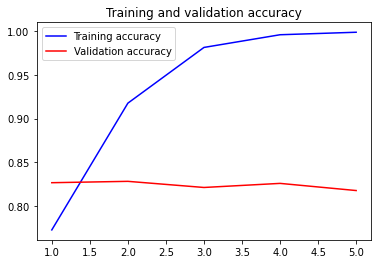

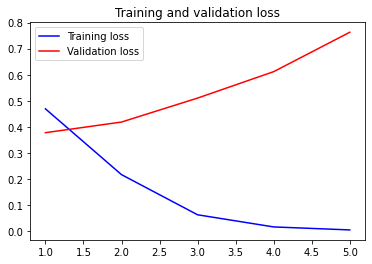

accuracy on test set 0.8315361775277387


,orig_title,cleaned_title,label,nums,pred,model_output
22911,Comedian Volodymyr Zelensky wins Ukrainian pre...,comedian volodymyr zelensky wins ukrainian pre...,0,"[6362, 14290, 22248, 5717, 5625, 28924, 17627,...",0.0,2.527833e-04
30369,The U.S. Navy's most advanced submarines will ...,the us navys most advanced submarines will soo...,0,"[1258, 19423, 20344, 25325, 23853, 13381, 1951...",0.0,5.100933e-02
24767,Georgia defends voting system despite 243-perc...,georgia defends voting system despite 243 perc...,0,"[27064, 10285, 10536, 21142, 17857, 21673, 277...",0.0,1.150280e-03
23030,Sam Smith Says He ‘Hated Every Minute’ of His ...,sam smith says he hated every minute of his os...,0,"[23808, 29478, 746, 1928, 27410, 13300, 13398,...",1.0,8.927158e-01
670,The Top 10 Top 10 Lists of 2013,the top 10 top 10 lists of 2013,0,"[1258, 21430, 8125, 21430, 8125, 8628, 4653, 3...",0.0,4.833223e-01
...,...,...,...,...,...,...
19336,Man drowns during lifeguard tryouts,man drowns during lifeguard tryouts,0,"[8835, 17201, 13262, 4293, 25302, 0, 0, 0, 0, ...",0.0,4.638731e-04
26286,More Elderly Americans Keeping Active By Maint...,more elderly americans keeping active by maint...,1,"[3062, 17605, 25746, 10381, 13493, 14806, 9370...",1.0,9.991043e-01
26441,Children struggle to hold pens because of exce...,children struggle to hold pens because of exce...,0,"[6313, 18518, 13837, 3558, 22575, 11075, 4653,...",0.0,1.556277e-04
27242,"Birds Have Fundamental Rights, Can't Be Kept i...",birds have fundamental rights cant be kept in ...,0,"[14941, 15467, 16897, 28486, 14564, 7417, 6491...",0.0,2.297411e-05


In [82]:
plot_train_validation(hist)
df_test_pred = get_pred_df(model, features_test, labels_test, df_test)
df_test_pred

### Trial 2: One-hot encode words, LSTM


In [69]:
def get_LSTM_model():
    embedding_dim=16

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vocab_set)+1, 64),
        tf.keras.layers.LSTM(64,  return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

model = get_LSTM_model()
hist = model.fit(features_train, labels_train, batch_size=32, epochs=5, verbose=2, validation_split=0.1)

Epoch 1/5
720/720 - 65s - loss: 0.6631 - accuracy: 0.6243 - val_loss: 0.6589 - val_accuracy: 0.6301
Epoch 2/5
720/720 - 59s - loss: 0.6218 - accuracy: 0.6664 - val_loss: 0.5898 - val_accuracy: 0.6703
Epoch 3/5
720/720 - 57s - loss: 0.5837 - accuracy: 0.6819 - val_loss: 0.5804 - val_accuracy: 0.6863
Epoch 4/5
720/720 - 51s - loss: 0.5597 - accuracy: 0.7187 - val_loss: 0.5737 - val_accuracy: 0.7285
Epoch 5/5
720/720 - 52s - loss: 0.5492 - accuracy: 0.7399 - val_loss: 0.5617 - val_accuracy: 0.7223


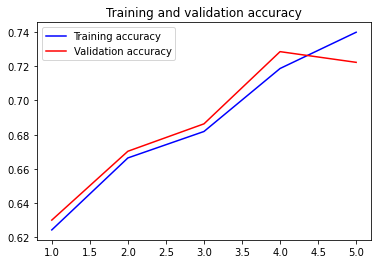

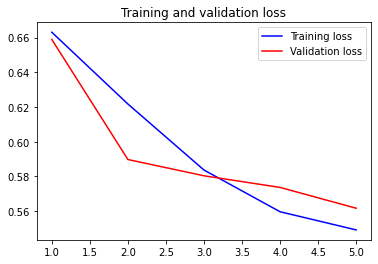

accuracy on test set 0.7158931082981715


,orig_title,cleaned_title,label,nums,pred
22911,Comedian Volodymyr Zelensky wins Ukrainian pre...,comedian volodymyr zelensky wins ukrainian pre...,0,"[6362, 14290, 22248, 5717, 5625, 28924, 17627,...",0.0
30369,The U.S. Navy's most advanced submarines will ...,the us navys most advanced submarines will soo...,0,"[1258, 19423, 20344, 25325, 23853, 13381, 1951...",0.0
24767,Georgia defends voting system despite 243-perc...,georgia defends voting system despite 243 perc...,0,"[27064, 10285, 10536, 21142, 17857, 21673, 277...",0.0
23030,Sam Smith Says He ‘Hated Every Minute’ of His ...,sam smith says he hated every minute of his os...,0,"[23808, 29478, 746, 1928, 27410, 13300, 13398,...",1.0
670,The Top 10 Top 10 Lists of 2013,the top 10 top 10 lists of 2013,0,"[1258, 21430, 8125, 21430, 8125, 8628, 4653, 3...",1.0
...,...,...,...,...,...
19336,Man drowns during lifeguard tryouts,man drowns during lifeguard tryouts,0,"[8835, 17201, 13262, 4293, 25302, 0, 0, 0, 0, ...",0.0
26286,More Elderly Americans Keeping Active By Maint...,more elderly americans keeping active by maint...,1,"[3062, 17605, 25746, 10381, 13493, 14806, 9370...",1.0
26441,Children struggle to hold pens because of exce...,children struggle to hold pens because of exce...,0,"[6313, 18518, 13837, 3558, 22575, 11075, 4653,...",0.0
27242,"Birds Have Fundamental Rights, Can't Be Kept i...",birds have fundamental rights cant be kept in ...,0,"[14941, 15467, 16897, 28486, 14564, 7417, 6491...",1.0


In [70]:
plot_train_validation(hist)
df_test_pred = get_pred_df(model, features_test, labels_test, df_test)
df_test_pred

### Trial 3: One-hot encode words, bidirectional LSTM

In [37]:
def get_bidirectional_LSTM_model():
    embedding_dim=16

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vocab_set)+1, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

model = get_bidirectional_LSTM_model()
hist = model.fit(features_train, labels_train, batch_size=32, epochs=5, verbose=2, validation_split=0.1)

Epoch 1/5
640/640 - 88s - loss: 0.4367 - accuracy: 0.7978 - val_loss: 0.3393 - val_accuracy: 0.8533
Epoch 2/5
640/640 - 78s - loss: 0.2009 - accuracy: 0.9257 - val_loss: 0.3885 - val_accuracy: 0.8426
Epoch 3/5
640/640 - 68s - loss: 0.0908 - accuracy: 0.9685 - val_loss: 0.5531 - val_accuracy: 0.8332
Epoch 4/5
640/640 - 67s - loss: 0.0464 - accuracy: 0.9837 - val_loss: 0.6772 - val_accuracy: 0.8254
Epoch 5/5
640/640 - 73s - loss: 0.0295 - accuracy: 0.9897 - val_loss: 0.7592 - val_accuracy: 0.8158


In [62]:
df_test_pred = get_pred_df(model, features_test, labels_test, df_test)
df_test_pred

accuracy on test set 0.819971870604782


,orig_title,cleaned_title,label,nums,pred
22911,Comedian Volodymyr Zelensky wins Ukrainian pre...,comedian volodymyr zelensky wins ukrainian pre...,0,"[6362, 14290, 22248, 5717, 5625, 28924, 17627,...",0.0
30369,The U.S. Navy's most advanced submarines will ...,the us navys most advanced submarines will soo...,0,"[1258, 19423, 20344, 25325, 23853, 13381, 1951...",0.0
24767,Georgia defends voting system despite 243-perc...,georgia defends voting system despite 243 perc...,0,"[27064, 10285, 10536, 21142, 17857, 21673, 277...",1.0
23030,Sam Smith Says He ‘Hated Every Minute’ of His ...,sam smith says he hated every minute of his os...,0,"[23808, 29478, 746, 1928, 27410, 13300, 13398,...",1.0
670,The Top 10 Top 10 Lists of 2013,the top 10 top 10 lists of 2013,0,"[1258, 21430, 8125, 21430, 8125, 8628, 4653, 3...",0.0
...,...,...,...,...,...
19336,Man drowns during lifeguard tryouts,man drowns during lifeguard tryouts,0,"[8835, 17201, 13262, 4293, 25302, 0, 0, 0, 0, ...",0.0
26286,More Elderly Americans Keeping Active By Maint...,more elderly americans keeping active by maint...,1,"[3062, 17605, 25746, 10381, 13493, 14806, 9370...",1.0
26441,Children struggle to hold pens because of exce...,children struggle to hold pens because of exce...,0,"[6313, 18518, 13837, 3558, 22575, 11075, 4653,...",0.0
27242,"Birds Have Fundamental Rights, Can't Be Kept i...",birds have fundamental rights cant be kept in ...,0,"[14941, 15467, 16897, 28486, 14564, 7417, 6491...",0.0


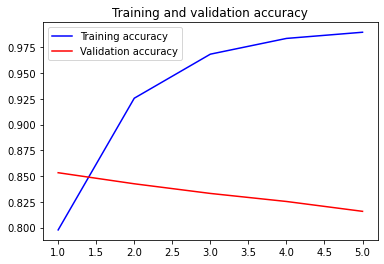

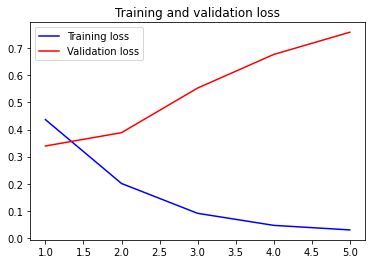

In [61]:
plot_train_validation(hist)
#seems to have overfit after first epoch

In [64]:
#fit again, stop after first epoch
model_earlystop = get_bidirectional_LSTM_model()
model_earlystop.fit(features_train, labels_train, batch_size=32, epochs=1, verbose=2, validation_split=0.1)
df_test_pred_early = get_pred_df(model_earlystop, features_test, labels_test, df_test)
df_test_pred_early

720/720 - 87s - loss: 0.4219 - accuracy: 0.8062 - val_loss: 0.3294 - val_accuracy: 0.8508
accuracy on test set 0.8556024378809189


,orig_title,cleaned_title,label,nums,pred
22911,Comedian Volodymyr Zelensky wins Ukrainian pre...,comedian volodymyr zelensky wins ukrainian pre...,0,"[6362, 14290, 22248, 5717, 5625, 28924, 17627,...",0.0
30369,The U.S. Navy's most advanced submarines will ...,the us navys most advanced submarines will soo...,0,"[1258, 19423, 20344, 25325, 23853, 13381, 1951...",0.0
24767,Georgia defends voting system despite 243-perc...,georgia defends voting system despite 243 perc...,0,"[27064, 10285, 10536, 21142, 17857, 21673, 277...",0.0
23030,Sam Smith Says He ‘Hated Every Minute’ of His ...,sam smith says he hated every minute of his os...,0,"[23808, 29478, 746, 1928, 27410, 13300, 13398,...",0.0
670,The Top 10 Top 10 Lists of 2013,the top 10 top 10 lists of 2013,0,"[1258, 21430, 8125, 21430, 8125, 8628, 4653, 3...",0.0
...,...,...,...,...,...
19336,Man drowns during lifeguard tryouts,man drowns during lifeguard tryouts,0,"[8835, 17201, 13262, 4293, 25302, 0, 0, 0, 0, ...",0.0
26286,More Elderly Americans Keeping Active By Maint...,more elderly americans keeping active by maint...,1,"[3062, 17605, 25746, 10381, 13493, 14806, 9370...",1.0
26441,Children struggle to hold pens because of exce...,children struggle to hold pens because of exce...,0,"[6313, 18518, 13837, 3558, 22575, 11075, 4653,...",0.0
27242,"Birds Have Fundamental Rights, Can't Be Kept i...",birds have fundamental rights cant be kept in ...,0,"[14941, 15467, 16897, 28486, 14564, 7417, 6491...",0.0


### Trial 4: One-hot encode words, cnn


In [78]:
def get_CNN_model():
    embedding_dim=16

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(vocab_set)+1, 64),
        tf.keras.layers.Conv1D(64, 3, padding = 'same', activation = 'relu'),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

model = get_CNN_model()
hist = model.fit(features_train, labels_train, batch_size=32, epochs=5, verbose=2, validation_split=0.1)

Epoch 1/5
720/720 - 29s - loss: 0.4695 - accuracy: 0.7725 - val_loss: 0.3780 - val_accuracy: 0.8266
Epoch 2/5
720/720 - 29s - loss: 0.2174 - accuracy: 0.9177 - val_loss: 0.4189 - val_accuracy: 0.8281
Epoch 3/5
720/720 - 29s - loss: 0.0635 - accuracy: 0.9816 - val_loss: 0.5107 - val_accuracy: 0.8211
Epoch 4/5
720/720 - 29s - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.6119 - val_accuracy: 0.8258
Epoch 5/5
720/720 - 27s - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.7629 - val_accuracy: 0.8176


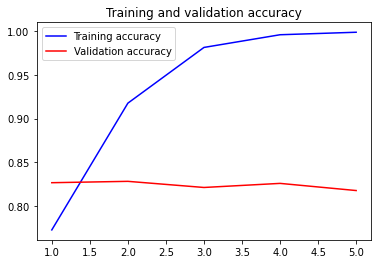

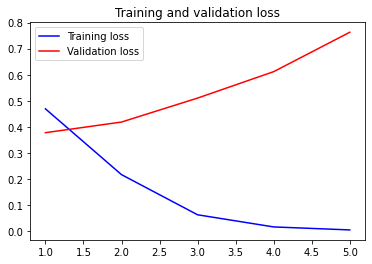

accuracy on test set 0.8315361775277387


,orig_title,cleaned_title,label,nums,pred
22911,Comedian Volodymyr Zelensky wins Ukrainian pre...,comedian volodymyr zelensky wins ukrainian pre...,0,"[6362, 14290, 22248, 5717, 5625, 28924, 17627,...",0.0
30369,The U.S. Navy's most advanced submarines will ...,the us navys most advanced submarines will soo...,0,"[1258, 19423, 20344, 25325, 23853, 13381, 1951...",0.0
24767,Georgia defends voting system despite 243-perc...,georgia defends voting system despite 243 perc...,0,"[27064, 10285, 10536, 21142, 17857, 21673, 277...",0.0
23030,Sam Smith Says He ‘Hated Every Minute’ of His ...,sam smith says he hated every minute of his os...,0,"[23808, 29478, 746, 1928, 27410, 13300, 13398,...",1.0
670,The Top 10 Top 10 Lists of 2013,the top 10 top 10 lists of 2013,0,"[1258, 21430, 8125, 21430, 8125, 8628, 4653, 3...",0.0
...,...,...,...,...,...
19336,Man drowns during lifeguard tryouts,man drowns during lifeguard tryouts,0,"[8835, 17201, 13262, 4293, 25302, 0, 0, 0, 0, ...",0.0
26286,More Elderly Americans Keeping Active By Maint...,more elderly americans keeping active by maint...,1,"[3062, 17605, 25746, 10381, 13493, 14806, 9370...",1.0
26441,Children struggle to hold pens because of exce...,children struggle to hold pens because of exce...,0,"[6313, 18518, 13837, 3558, 22575, 11075, 4653,...",0.0
27242,"Birds Have Fundamental Rights, Can't Be Kept i...",birds have fundamental rights cant be kept in ...,0,"[14941, 15467, 16897, 28486, 14564, 7417, 6491...",0.0


In [79]:
plot_train_validation(hist)
df_test_pred = get_pred_df(model, features_test, labels_test, df_test)
df_test_pred

In [1]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_test_pred.label, df_test_pred.model_output)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'df_test_pred' is not defined

# PART 4: Using Word2Vec

### Trial 5: word2vec, global average pooling 
### Trial 6: word2vec, LSTM
### Trial 7: word2vec, bidirectional LSTM
### Trial 8: word2vec, xgboost